# Mixed-effects linear model

With statsmodels. But here we fit a model on the whole dataset and predict on it also, to give a topline of the possible prediction performance.

In [2]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_theme()
plt.rc('axes', labelsize=18, titlesize=20) 
plt.rc("legend", fontsize=16)

## Loading Data

In [4]:
os.chdir("D:\Hugo\Anaphase\Structured")
data = pd.read_csv("Measures_BFf0001_H449pos2_merged.csv", sep=";", comment="#", index_col="idx")
data = data[(data["time_to_anaphase"] >= 0) & (data["time"] > 0)].dropna()

print(data.shape)
data.head()

(1497, 25)


,frame,time,mom_ID,daugh_ID,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,...,daugh_ecc,relat_ecc,mom_circ,daugh_circ,relat_circ,inter_centroid_dist,relat_inter_centroid_distance,anaphase,time_to_anaphase,movie_name
idx,,,,,,,,,,,,,,,,,,,,,
0,18,1,11.0,808.0,371.062921,331.552239,363.365629,323.352941,191.299472,8.534336,...,0.820408,1.023012,0.847407,0.816201,0.963175,10.630146,0.244912,False,32,H449_pos2
0,19,2,11.0,808.0,371.495880,331.623188,363.063983,323.421053,196.299472,11.250034,...,0.830933,0.998219,0.843124,0.852575,1.011209,12.041595,0.274090,False,31,H449_pos2
0,20,3,11.0,808.0,371.800227,331.260870,363.057890,323.047619,196.299472,13.681430,...,0.938263,1.195639,0.843124,0.776800,0.921335,12.041595,0.264806,False,30,H449_pos2
0,21,4,11.0,808.0,370.928592,331.567164,362.200747,323.142857,192.583774,14.965732,...,0.856876,1.053357,0.872175,0.920806,1.055758,11.313708,0.252302,False,29,H449_pos2
0,22,5,11.0,808.0,372.133561,331.000000,363.010271,322.904762,193.015171,16.397129,...,0.925441,1.101654,0.811349,0.861788,1.062168,12.727922,0.281578,False,28,H449_pos2


# 1. Single feature : daughter perimeter

In [4]:
# prepare the training set
from sklearn.model_selection import train_test_split

features = "daugh_per"

data = data[data[features] > 0].drop(data[data["daugh_per"] >= 50].index)

data[features] = (data[features] - data[features].mean()) / data[features].std() # dataset-wise standardization

X, y = data[features].values, data["time_to_anaphase"]
# X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"], train_size=0.5)
# X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [5]:
md = smf.mixedlm("time_to_anaphase ~ daugh_per", data, groups=data.index)
mdf = md.fit()

print(mdf.summary())

print("\nFIXED EFFECTS:")
print(mdf.fe_params["Intercept"], mdf.fe_params["daugh_per"])

print("\nRANDOM EFFECTS:")
print(mdf.cov_re)

rmses = (mdf.fittedvalues - data["time_to_anaphase"]) ** 2
rmse = np.sqrt(np.mean(rmses))
std = np.sqrt(np.std(rmses))
print(f"\nMean RMSE: {round(rmse, 2)} +- {round(std, 2)} min.")

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_to_anaphase
No. Observations: 1497    Method:             REML            
No. Groups:       132     Scale:              9.2669          
Min. group size:  2       Log-Likelihood:     -4017.8535      
Max. group size:  43      Converged:          Yes             
Mean group size:  11.3                                        
---------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept     12.449     0.535    23.274  0.000  11.401  13.498
daugh_per     -8.655     0.085  -101.411  0.000  -8.822  -8.487
Group Var     36.161     1.603                                 


FIXED EFFECTS:
12.449482673702327 -8.654686499194549

RANDOM EFFECTS:
           Group
Group  36.160655

Mean RMSE: 2.91 +- 4.34 min.


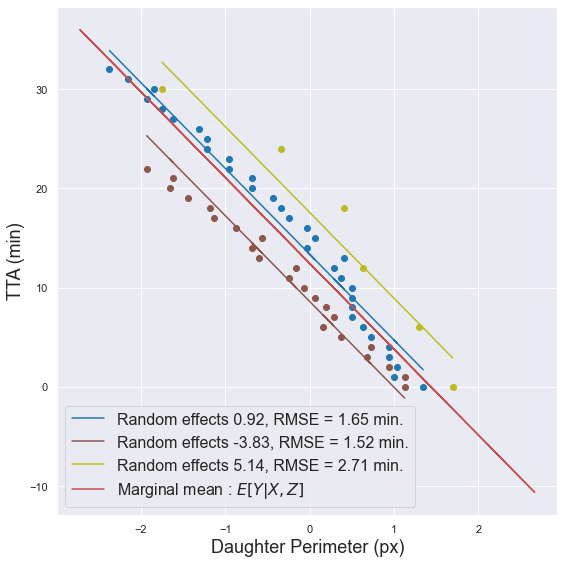

In [6]:
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

plot = True
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    indices_to_plot = [0, 25, 98]
    
    for idx in indices_to_plot:
        ax.scatter(data.loc[idx]["daugh_per"], data.loc[idx]["time_to_anaphase"], c=names[idx % len(names)]) #, label="Train set")
        rmse = np.sqrt(np.mean((mdf.fittedvalues.loc[idx] - data.loc[idx]["time_to_anaphase"]) ** 2))
        ax.plot(data.loc[idx]["daugh_per"],  mdf.fittedvalues.loc[idx], c=names[idx % len(names)], label=f"Random effects {round(mdf.random_effects[idx][0], 2)}, RMSE = {round(rmse, 2)} min.")
        
    ax.plot(data["daugh_per"], data["daugh_per"] * mdf.fe_params["daugh_per"] + mdf.fe_params["Intercept"], c="r", label="Marginal mean : $E[Y | X, Z]$")
    
    ax.set_xlabel("Daughter Perimeter (px)")
    ax.set_ylabel("TTA (min)")
    ax.legend()
    fig.tight_layout()
    
    plt.savefig("D:/Documents/STAGE/Rapport/Images/tta_regression_mixed_effects_model.pdf", format="pdf")

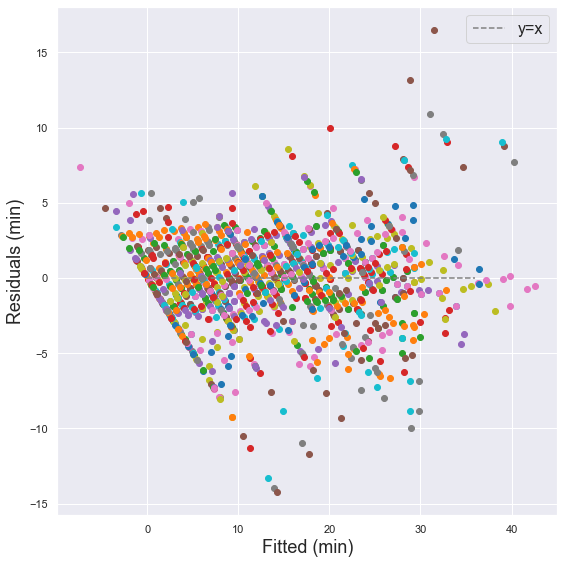

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
indices_to_plot = data.index.unique()

for idx in indices_to_plot:
    ax.scatter(mdf.fittedvalues.loc[idx], data.loc[idx]["time_to_anaphase"] - mdf.fittedvalues.loc[idx], c=names[idx % len(names)]) #, label="Train set")
#     ax.plot(data.loc[idx]["daugh_per"],  mdf.fittedvalues.loc[idx], c=names[idx % len(names)], label=f"Random effects {round(mdf.random_effects[idx][0], 2)}, RMSE = {round(rmse, 2)} min.")

# ax.plot(data["daugh_per"], data["daugh_per"] * mdf.fe_params["daugh_per"] + mdf.fe_params["Intercept"], c="r", label="Marginal mean : $E[Y | X, Z]$")
ax.plot([0, 36], [0, 0], "--", c="grey", label="y=x")

ax.set_xlabel("Fitted (min)")
ax.set_ylabel("Residuals (min)")
ax.legend()
fig.tight_layout()

plt.savefig("D:/Documents/STAGE/Rapport/Images/tta_regression_mixed_effects_model_residuals_vs_fitted.pdf", format="pdf")

## Iterated cross-validation

In [15]:
from sklearn.model_selection import RepeatedKFold

os.chdir("D:\Hugo\Anaphase\Structured")
data = pd.read_csv("Measures_BFf0001_H449pos2_merged.csv", sep=";", comment="#", index_col="idx")
data = data[(data["time_to_anaphase"] >= 0) & (data["time"] > 0)].dropna()

features = "daugh_per"
data = data[data[features] > 0].drop(data[data["daugh_per"] >= 50].index)
data[features] = (data[features] - data[features].mean()) / data[features].std() # dataset-wise standardization

X, y = data[features].values.reshape(-1, 1), data["time_to_anaphase"].values
n_folds, n_iter = 2, 100
kf = RepeatedKFold(n_splits=n_folds, n_repeats=n_iter)

rmses, stds, scores = [], [], []
for train_idx, test_idx in kf.split(data.index):
    X = data.iloc[train_idx]
    
    md = smf.mixedlm("time_to_anaphase ~ daugh_per", X, groups=X.index)
    mdf = md.fit()
    
    rmses.append(np.sqrt(np.mean((mdf.fittedvalues - X["time_to_anaphase"]) ** 2)))
    
rmses = np.array(rmses)

print(f"RMSE on {n_folds} folds repeated {n_iter} times : {rmses}")
print(f"Mean RMSE on {n_folds}-fold cross-validation repeated {n_iter} times : {round(rmses.mean(), 2)}  +- {round(rmses.std(), 2)} min.")

RMSE on 2 folds repeated 100 times : [2.72394293 2.79637686 2.61213873 2.74417885 2.95442077 2.57860432
 2.76179506 2.75985916 2.63716589 2.9137681  2.77915799 2.67093203
 2.83317434 2.60342425 2.79757216 2.67921073 2.61400729 2.86607202
 2.67988433 2.81832409 2.66107258 2.78310939 2.68808014 2.71339157
 2.79119161 2.73832867 2.74676035 2.73875654 2.90073123 2.53984248
 2.88402352 2.65341753 2.64000495 2.93670048 2.69037417 2.795891
 2.60261479 2.91806118 2.6581433  2.93310067 2.77817663 2.64001384
 2.79452399 2.6181607  2.6517547  2.79006419 2.68750959 2.79814945
 2.57727578 2.86072299 2.67730418 2.71389994 2.91412358 2.59879721
 2.86177704 2.71585328 2.87146832 2.69481416 2.88142498 2.62695301
 2.76096634 2.79548613 2.74649817 2.76767048 2.68907613 2.8271156
 2.84659484 2.7194641  2.93449202 2.48523004 2.64528649 2.7794353
 2.75165698 2.76170699 2.71481637 2.78605681 2.92791742 2.59616308
 2.74673393 2.76094888 2.66084338 2.92262588 2.63443555 2.83726279
 2.73030206 2.76882441 2.8576